# KNN Classification Pipeline for Song Popularity

This notebook implements a complete scikit-learn pipeline for KNN classification to predict song popularity categories.

## 1. Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler
import joblib


## 2. Create Custom Transformers

In [26]:
# Custom transformer to create popularity categories
class PopularityCategorizer:
    def __init__(self, n_categories=4):
        self.n_categories = n_categories
        self.bins = None
        self.labels = ['Low', 'Medium-Low', 'Medium-High', 'High'] if n_categories == 4 else None
    
    def fit(self, X, y=None):
        # Calculate quantile bins during fit
        self.bins = pd.qcut(X, q=self.n_categories, retbins=True, duplicates='drop')[1]
        return self
    
    def transform(self, X):
        # Use the calculated bins to categorize
        return pd.cut(X, bins=self.bins, labels=self.labels, include_lowest=True)
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Custom transformer for feature selection and cleaning
class FeatureSelector:
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.feature_names]

## 3. Load and Prepare Data

In [27]:
# Load the dataset
df = pd.read_csv('EDA-tracks.csv')

# Clean the data
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'], axis=1)
if 'track_id' in df.columns:
    df = df.drop(columns=['track_id'], axis=1)

# Define features
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 
                     'tempo', 'duration_ms', 'key', 'mode', 'time_signature']

# Prepare X and y
X = df.copy()
y = df['popularity']

# Convert categorical features to numeric
X['mode'] = X['mode'].astype(int)
X['key'] = X['key'].astype(int)
X['time_signature'] = X['time_signature'].astype(int)

print(f"Dataset shape: {X.shape}")
X.head()

Dataset shape: (1500, 17)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,tempo_bins
0,85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,club,Medium
1,49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,club,Medium
2,65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,club,Fast
3,59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,club,Medium
4,55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,club,Fast


## 4. Create the Pipeline

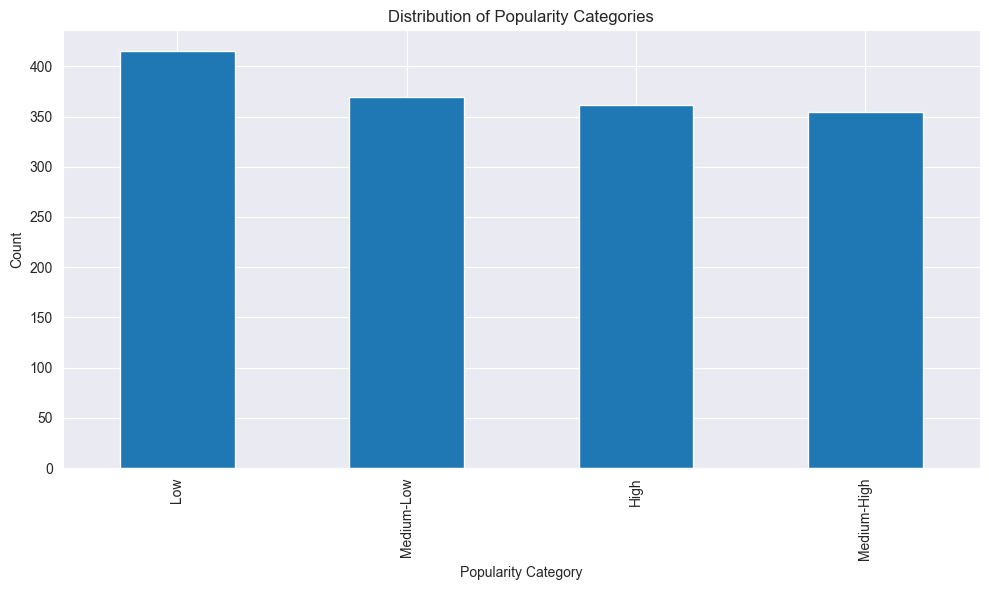

In [28]:
# Create the main pipeline
knn_pipeline = Pipeline([
    # Step 1: Select features
    ('feature_selector', FeatureSelector(numerical_features)),
    
    # Step 2: Scale features
    ('scaler', RobustScaler()),
    
    # Step 3: KNN classifier
    ('classifier', KNeighborsClassifier())
])

# Create a separate pipeline for target transformation
target_transformer = PopularityCategorizer(n_categories=4)

# Create popularity categories
y_cat = target_transformer.fit_transform(y)

# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
y_cat.value_counts().plot(kind='bar')
plt.title('Distribution of Popularity Categories')
plt.xlabel('Popularity Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. Split Data and Find Optimal Parameters

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 19, 23, 27],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform grid search
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 27, 'classifier__weights': 'distance'}
Best cross-validation accuracy: 0.493


## 6. Evaluate the Best Model

Test accuracy: 0.507

Classification Report:
              precision    recall  f1-score   support

        High       0.52      0.44      0.48        72
         Low       0.49      0.73      0.59        83
 Medium-High       0.56      0.31      0.40        71
  Medium-Low       0.49      0.50      0.49        74

    accuracy                           0.51       300
   macro avg       0.52      0.50      0.49       300
weighted avg       0.52      0.51      0.49       300



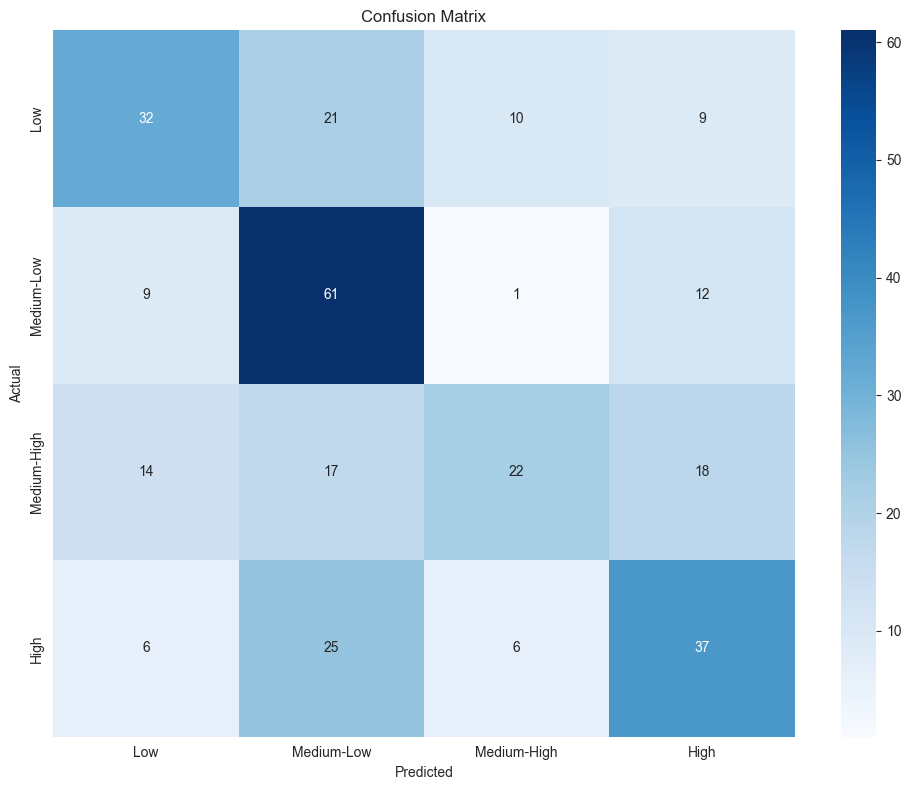

In [30]:
#### Get the best pipeline
best_pipeline = grid_search.best_estimator_

# Make predictions
y_pred = best_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.3f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium-Low', 'Medium-High', 'High'],
            yticklabels=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 7. Cross-Validation with the Best Pipeline

Cross-validation scores: [0.4625     0.53333333 0.50833333 0.5        0.50416667]
Mean CV accuracy: 0.502 (+/- 0.046)


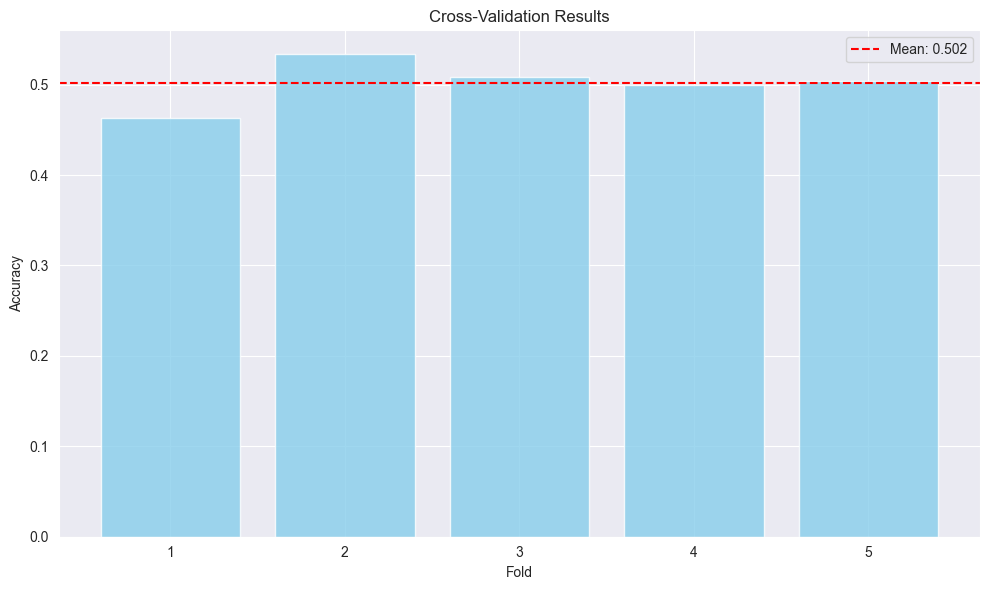

In [9]:
# Perform cross-validation with the best pipeline
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Visualize CV results
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, alpha=0.8, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Results')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Save the Pipeline

In [10]:
# Save the complete pipeline (including target transformer)
pipeline_package = {
    'pipeline': best_pipeline,
    'target_transformer': target_transformer,
    'feature_names': numerical_features
}

# Save to file
joblib.dump(pipeline_package, 'knn_popularity_pipeline.joblib')
print("Pipeline saved successfully!")

Pipeline saved successfully!


## 9. Using the Saved Pipeline for Predictions

In [11]:
# Example of loading and using the saved pipeline
loaded_package = joblib.load('knn_popularity_pipeline.joblib')
loaded_pipeline = loaded_package['pipeline']
loaded_target_transformer = loaded_package['target_transformer']
loaded_features = loaded_package['feature_names']

# Make a prediction on a new song
sample_song = X_test.iloc[0:1]
prediction = loaded_pipeline.predict(sample_song)
prediction_proba = loaded_pipeline.predict_proba(sample_song)

print("Sample song features:")
print(sample_song[loaded_features])
print(f"\nPredicted popularity category: {prediction[0]}")
print("\nPrediction probabilities:")
for i, category in enumerate(['Low', 'Medium-Low', 'Medium-High', 'High']):
    print(f"{category}: {prediction_proba[0][i]:.3f}")

Sample song features:
      danceability  energy  loudness  speechiness  acousticness  \
1044         0.594  0.0852   -20.606       0.0533         0.994   

      instrumentalness  liveness  valence    tempo  duration_ms  key  mode  \
1044             0.937     0.101    0.626  127.091       187520    7     1   

      time_signature  
1044               4  

Predicted popularity category: Medium-Low

Prediction probabilities:
Low: 0.215
Medium-Low: 0.112
Medium-High: 0.193
High: 0.480


## 10. Create a Function for Easy Prediction

In [12]:
def predict_song_popularity(song_features, pipeline_path='knn_popularity_pipeline.joblib'):

    package = joblib.load(pipeline_path)
    pipeline = package['pipeline']
    
    # Convert dict to DataFrame if necessary
    if isinstance(song_features, dict):
        song_df = pd.DataFrame([song_features])
    else:
        song_df = song_features
    
    # Ensure all numeric features are properly typed
    for col in ['mode', 'key', 'time_signature']:
        if col in song_df.columns:
            song_df[col] = song_df[col].astype(int)
    
    # Make prediction
    prediction = pipeline.predict(song_df)
    prediction_proba = pipeline.predict_proba(song_df)
    
    # Create result dictionary
    result = {
        'predicted_category': prediction[0],
        'probabilities': {
            'Low': prediction_proba[0][0],
            'Medium-Low': prediction_proba[0][1],
            'Medium-High': prediction_proba[0][2],
            'High': prediction_proba[0][3]
        }
    }
    
    return result

# Example usage
example_song = {
    'danceability': 0.7,
    'energy': 0.8,
    'loudness': -5.0,
    'speechiness': 0.05,
    'acousticness': 0.1,
    'instrumentalness': 0.0,
    'liveness': 0.1,
    'valence': 0.6,
    'tempo': 120.0,
    'duration_ms': 200000,
    'key': 5,
    'mode': 1,
    'time_signature': 4
}

result = predict_song_popularity(example_song)
print("\nPrediction for example song:")
print(f"Category: {result['predicted_category']}")
print("\nProbabilities:")
for category, prob in result['probabilities'].items():
    print(f"{category}: {prob:.3f}")


Prediction for example song:
Category: High

Probabilities:
Low: 0.401
Medium-Low: 0.324
Medium-High: 0.137
High: 0.137


## 11. Pipeline Visualization

In [13]:
# Visualize the pipeline structure
from sklearn import set_config
set_config(display='diagram')

# Display the pipeline
best_pipeline

Pipeline(steps=[('feature_selector',
                 <__main__.FeatureSelector object at 0x000001D7DB867C50>),
                ('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=15,
                                      weights='distance'))])

## 12. Summary and Deployment

In [16]:
# Create a deployment package
deployment_package = {
    'pipeline': best_pipeline,
    'target_transformer': target_transformer,
    'feature_names': numerical_features,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy,
    'cv_scores': cv_scores.tolist(),
    'category_mapping': {
        0: 'Low',
        1: 'Medium-Low',
        2: 'Medium-High',
        3: 'High'
    }
}

# Save deployment package
joblib.dump(deployment_package, 'knn_popularity_deployment.joblib')

# Print deployment summary
print("===== Deployment Summary =====")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Test accuracy: {accuracy:.3f}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f}")
print(f"\nRequired features for prediction:")
for i, feature in enumerate(numerical_features, 1):
    print(f"{i}. {feature}")
print("\nPipeline and deployment package saved successfully!")

===== Deployment Summary =====
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Test accuracy: 0.483
Mean CV accuracy: 0.502

Required features for prediction:
1. danceability
2. energy
3. loudness
4. speechiness
5. acousticness
6. instrumentalness
7. liveness
8. valence
9. tempo
10. duration_ms
11. key
12. mode
13. time_signature

Pipeline and deployment package saved successfully!
